In [10]:
from infrastructure.classes import Experiment, TrainParameters
from infrastructure.training import train
import torch

experiment = Experiment(
    tensor_parameters=dict(dtype=torch.float32, device=torch.device("cpu")),
    dataset_name="funnel",
    dataset_parameters={
        "target_dimension":2
    },
    dataset_number_of_points=10**5,
    dataloader_parameters=dict(batch_size=256, shuffle=True),
    pushforward_operator_name="amortized_neural_quantile_regression",
    pushforward_operator_parameters=dict(
        feature_dimension=1,
        response_dimension=2,
        hidden_dimension=18,
        number_of_hidden_layers=8,
        potential_to_estimate_with_neural_network="u",
    ),
    train_parameters=TrainParameters(
        number_of_epochs_to_train=25,
        verbose=True,
        optimizer_parameters=dict(
            lr=1e-2,
            weight_decay=1e-4
        ),
        scheduler_parameters=dict(eta_min=0),
        warmup_iterations=3,
    )
)

model = train(experiment)
_ = model.eval()

Warm up iteration: 3 Potential loss: 0.036, Amortization loss: 0.007: 100%|██████████| 3/3 [00:08<00:00,  2.69s/it]
Epoch: 25, Potential Objective: 0.859, Amortization Objective: 0.124, Potential LR: 0.000000, Amortized LR: 0.001216: 100%|██████████| 25/25 [18:48<00:00, 45.15s/it]


In [12]:
%matplotlib qt
from datasets import FunnelDistribution
import matplotlib.pyplot as plt

dataset = FunnelDistribution({}, target_dimension=2)
X, Y = dataset.sample_joint(1000)
U = torch.randn_like(Y)
Y_approximated = model.push_u_given_x(u=U, x=X)

fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')
ax.scatter(X[:, 0], Y[:, 0], Y[:, 1])
ax.set_title("Funnel_2")

ax = fig.add_subplot(122, projection='3d')
ax.scatter(X[:, 0], Y_approximated[:, 0], Y_approximated[:, 1])
ax.set_title("Funnel_2")

plt.show()

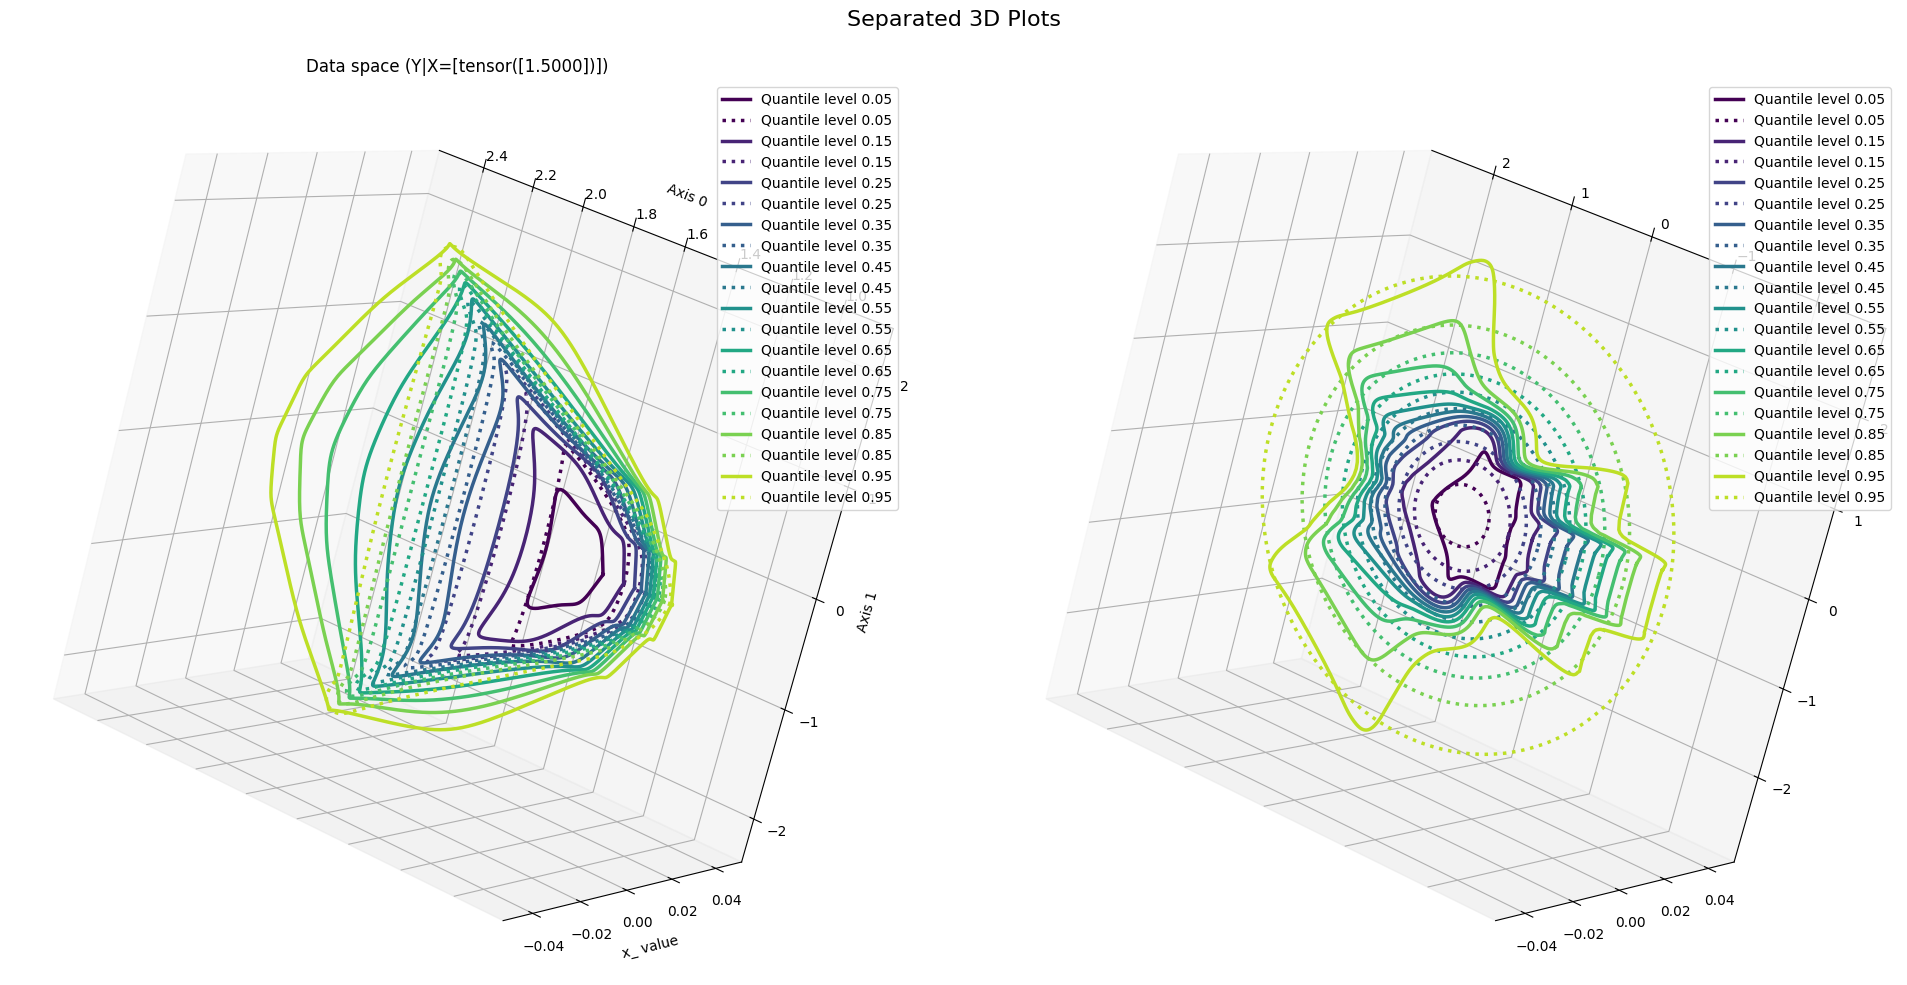

In [7]:
%matplotlib inline
from datasets import PICNN_FNLVQR_Star, PICNN_FNLVQR_Banana
from utils.plot import plot_quantile_levels_from_dataset

dataset = PICNN_FNLVQR_Banana(tensor_parameters=experiment.tensor_parameters)
plot_quantile_levels_from_dataset(
    model=model,
    dataset=dataset,
    conditional_value=torch.tensor([[1.5]]),
    number_of_quantile_levels=10,
    tensor_parameters=experiment.tensor_parameters
)